In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
data_folder = '/kaggle/input/otids-can/'
print(os.listdir(data_folder))

['Impersonation_attack_dataset.txt', 'Attack_free_dataset.txt', 'DoS_attack_dataset.txt', 'Fuzzy_attack_dataset.txt']


In [3]:
dos_data_path = os.path.join(data_folder, 'DoS_attack_dataset.txt')
benign_data_path = os.path.join(data_folder, 'Attack_free_dataset.txt')
fuzzy_data_path = os.path.join(data_folder, 'Fuzzy_attack_dataset.txt')
impersonation_data_path = os.path.join(data_folder, 'Impersonation_attack_dataset.txt')

In [4]:
def hex_to_bin(hex_num):
    
    binary_value = bin(int(str(hex_num), 16))[2:]
    
    return binary_value

def int_to_bin(int_num):
    
    binary_value = bin(int_num)[2:]
    
    return binary_value

def pad(value, length):
    
    curr_length = len(str(value))
    
    zeros = '0' * (length - curr_length)
    
    return zeros + value

hex_to_dec = lambda x: int(x, 16)

In [5]:
## Since there are varying DLCs (2,5,6,8) in order to maintain data integrity
## The data must be padded with 00s when DLC < 8

def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['dlc'] == dlc, df.columns[3:]] = df.loc[df['dlc'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df
    

In [6]:
def read_txt_data(data_path):

    timestamps = []
    ids = []
    dlcs = []
    data = []

    # Read the data from the file
    with open(data_path, 'r') as file:
        for line in file:
            
            # Extract information from each line
            line = line.strip()
            ts = line.split("Timestamp: ")[1].strip().split(' ')[0]
            can_id = line.split('ID: ')[1].split()[0]
            dlc = line.split('DLC: ')[1].split()[0]
            can_data = ''.join(line.split('DLC: ')[-1].split()[-8:])

            #Converting Hexadecimal entries to decimal format
            timestamps.append(float(ts))
            ids.append(hex_to_dec(can_id))
            dlcs.append(int(dlc))
            data.append(hex_to_dec(can_data))

        df = pd.DataFrame({
        'timestamp': timestamps,
        'can_id': ids,
        'dlc': dlcs,
        'data': data
    })
    
    ##Sorting dataframe by timestamp
    df.sort_values(by = ['timestamp'], inplace = True)
    
    ## Creating IAT column
    df = df.assign(IAT=df['timestamp'].diff().fillna(0))
    return df

In [7]:
##Reading datasets
dos_data = read_txt_data(dos_data_path)
benign_data = read_txt_data(benign_data_path)
fuzzy_data = read_txt_data(fuzzy_data_path)
impersonation_data = read_txt_data(impersonation_data_path)

In [8]:
#Timestamps on the impersonation dataset do not start with 0, thus normalizing timestamps with respect to first datapoints
impersonation_data['timestamp'] = impersonation_data['timestamp'] - impersonation_data['timestamp'].iloc[0]

In [ ]:
##LABELS FOR DATAPOINTS

## Benign -> 0
## DOS -> 1
## Fuzzy -> 2
## Impersonation -> 3

In [9]:
## Setting the labels
benign_data['label'] = 0
dos_data['label'] = dos_data['can_id'].apply(lambda x : 1 if x == 0 else 1)

## In these two datasets, entries past the 250 sec mark have attacks and benign datapoints.
## No specific labels after that, so we label all of them as attacks which will cause some mislabelling, which is reflected in the results
fuzzy_data['label'] = fuzzy_data['timestamp'].apply(lambda x : 2 if x >= 250 else 0)
impersonation_data['label'] = impersonation_data['timestamp'].apply(lambda x : 3 if x >= 250 else 0)

In [10]:
all_data = pd.concat([dos_data, benign_data, fuzzy_data, impersonation_data], axis=0, ignore_index=True)
all_data.drop(columns = ['timestamp'], inplace=True, axis=1)

In [11]:
## Number of datapoints by label
all_data['label'].value_counts()

0    3333261
1     656579
3     479889
2     143710
Name: label, dtype: int64

In [12]:
X = all_data.drop(columns = ['label'])
y = all_data['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
print(X_train.shape)

(3690751, 4)


In [15]:
print(X_test.shape)

(922688, 4)


In [16]:
y_train.value_counts()

0    2666963
1     525096
3     383939
2     114753
Name: label, dtype: int64

In [25]:
y_test.value_counts()

0    666589
1    131364
3     95929
2     28806
Name: label, dtype: int64

In [26]:
## Function to create sequences for datapoints for LSTM model
def sequencify(dataset, target, start, end, window):
  
    X = []
    y = []
    
    start = start + window 
    if end is None:
        end = len(dataset)
        
    for i in tqdm(range(start, end+1)):
        indices = range(i-window, i) 
        X.append(dataset[indices])
        
        indicey = i -1
        y.append(target[indicey])
			
    return np.array(X), np.array(y)

In [17]:
## Normalizing data

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
##MLP

print("-----MLP-------")

mlp = Sequential()
mlp.add(Input(shape = (4)))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(4))

mlp.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

mlp_hist = mlp.fit(X_train, y_train, epochs=100, callbacks = [es], validation_split=0.2, batch_size = 4096)

##MLP
print("-----MLP-------")

mlp_preds = mlp.predict(X_test)
mlp_preds = mlp_preds.argmax(axis = 1)

print("ACCURACY: ", accuracy_score(y_test, mlp_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, mlp_preds))

-----MLP-------
Epoch 1/100
721/721 [==============================] - 9s 6ms/step - loss: 0.6868 - accuracy: 0.7862 - val_loss: 0.6440 - val_accuracy: 0.7936
Epoch 2/100
721/721 [==============================] - 3s 5ms/step - loss: 0.6364 - accuracy: 0.7937 - val_loss: 0.6267 - val_accuracy: 0.7935
Epoch 3/100
721/721 [==============================] - 3s 4ms/step - loss: 0.6194 - accuracy: 0.7944 - val_loss: 0.6122 - val_accuracy: 0.7956
Epoch 4/100
721/721 [==============================] - 3s 5ms/step - loss: 0.6064 - accuracy: 0.7977 - val_loss: 0.6002 - val_accuracy: 0.7992
Epoch 5/100
721/721 [==============================] - 3s 4ms/step - loss: 0.5979 - accuracy: 0.7993 - val_loss: 0.5954 - val_accuracy: 0.7991
Epoch 6/100
721/721 [==============================] - 3s 4ms/step - loss: 0.5910 - accuracy: 0.8000 - val_loss: 0.5871 - val_accuracy: 0.8005
Epoch 7/100
721/721 [==============================] - 3s 5ms/step - loss: 0.5854 - accuracy: 0.8004 - val_loss: 0.5819 - val_

Exception ignored in: <function _xla_gc_callback at 0x790413f18e50>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


28834/28834 [==============================] - 50s 2ms/step
ACCURACY:  0.8060406117777623
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88    666589
           1       0.83      0.69      0.76    131364
           2       0.32      0.00      0.01     28806
           3       0.50      0.04      0.08     95929

    accuracy                           0.81    922688
   macro avg       0.61      0.43      0.43    922688
weighted avg       0.76      0.81      0.75    922688



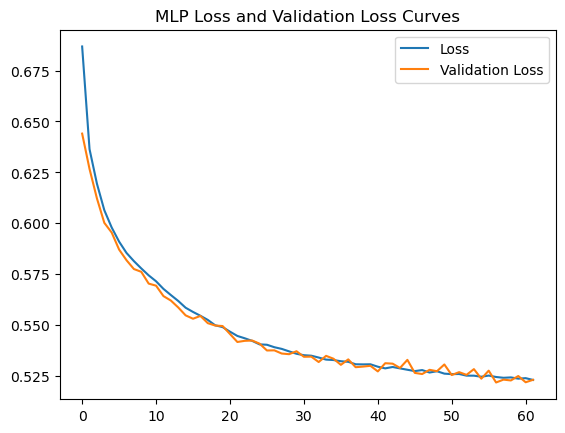

In [30]:
plt.plot(mlp_hist.history['loss'], label = 'Loss')
plt.plot(mlp_hist.history['val_loss'], label = 'Validation Loss')
plt.title('MLP Loss and Validation Loss Curves')

plt.legend(loc = 'best')
plt.show()

In [31]:
X_train_seq, y_train_seq = sequencify(X_train, y_train.values, start = 0, end = None, window = 10)
print(X_train_seq.shape, y_train_seq.shape)

print(type(X_train_seq))

100%|██████████| 3690742/3690742 [00:38<00:00, 96242.66it/s] 


(3690742, 10, 4) (3690742,)
<class 'numpy.ndarray'>


In [32]:
X_test_seq, y_test_seq = sequencify(X_test, y_test.values, start = 0, end = None, window = 10)
print(X_test_seq.shape, y_test_seq.shape)

100%|██████████| 922679/922679 [00:10<00:00, 89487.84it/s] 


(922679, 10, 4) (922679,)


In [35]:
##LSTM

print("-----LSTM-------")

lstm = Sequential()

lstm.add(Input(shape = X_train_seq.shape[1:]))
lstm.add(LSTM(128, activation = 'relu'))
lstm.add(Dense(4, activation = 'softmax'))

lstm.compile(
    loss = SparseCategoricalCrossentropy(from_logits = False),
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

lstm_hist = lstm.fit(X_train_seq, y_train_seq, batch_size = 1024, validation_split = 0.2,
        callbacks = [es], epochs = 1000)

print("-----LSTM-------")

lstm_preds = lstm.predict(X_test_seq, batch_size = 1024)
lstm_preds = lstm_preds.argmax(axis = 1)

print("ACCURACY: ", accuracy_score(y_test_seq, lstm_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test_seq, lstm_preds))

-----LSTM-------
Epoch 1/1000
2884/2884 [==============================] - 78s 26ms/step - loss: 0.6950 - accuracy: 0.7866 - val_loss: 0.6552 - val_accuracy: 0.7940
Epoch 2/1000
2884/2884 [==============================] - 76s 26ms/step - loss: 0.6498 - accuracy: 0.7944 - val_loss: 0.6439 - val_accuracy: 0.7950
Epoch 3/1000
2884/2884 [==============================] - 77s 27ms/step - loss: 0.6398 - accuracy: 0.7950 - val_loss: 0.6355 - val_accuracy: 0.7951
Epoch 4/1000
2884/2884 [==============================] - 76s 27ms/step - loss: 0.6319 - accuracy: 0.7953 - val_loss: 0.6283 - val_accuracy: 0.7955
Epoch 5/1000
2884/2884 [==============================] - 76s 27ms/step - loss: 0.6265 - accuracy: 0.7955 - val_loss: 0.6238 - val_accuracy: 0.7955
Epoch 6/1000
2884/2884 [==============================] - 80s 28ms/step - loss: 0.6228 - accuracy: 0.7956 - val_loss: 0.6204 - val_accuracy: 0.7959
Epoch 7/1000
2884/2884 [==============================] - 75s 26ms/step - loss: 0.6199 - accura

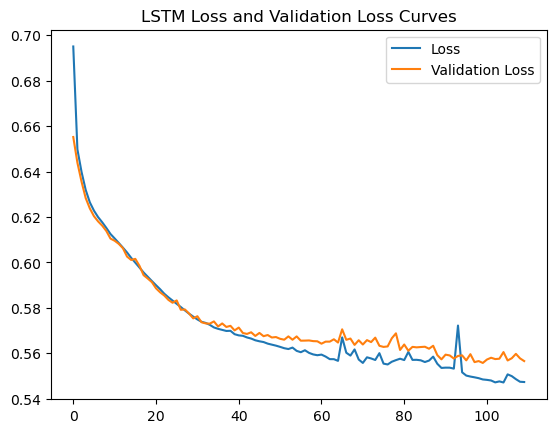

In [36]:
plt.plot(lstm_hist.history['loss'], label = 'Loss')
plt.plot(lstm_hist.history['val_loss'], label = 'Validation Loss')
plt.title('LSTM Loss and Validation Loss Curves')

plt.legend(loc = 'best')
plt.show()

In [18]:
## XGBOOST

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("-------XGBOOST-------")
print("ACCURACY: ", accuracy_score(y_test, xgb_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, xgb_preds))

-------XGBOOST-------
ACCURACY:  0.8595830876742734
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91    666298
           1       0.91      0.78      0.84    131483
           2       0.65      0.07      0.12     28957
           3       0.77      0.46      0.58     95950

    accuracy                           0.86    922688
   macro avg       0.80      0.57      0.61    922688
weighted avg       0.85      0.86      0.84    922688



In [41]:
## DECISION TREE

dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print("-------DECISION TREE--------")
print("ACCURACY: ", accuracy_score(y_test, dt_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, dt_preds))


-------DECISION TREE--------
ACCURACY:  0.7953479399320247


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88    666589
           1       1.00      0.51      0.68    131364
           2       0.00      0.00      0.00     28806
           3       0.00      0.00      0.00     95929

    accuracy                           0.80    922688
   macro avg       0.44      0.38      0.39    922688
weighted avg       0.71      0.80      0.73    922688



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:

## RANDOM FOREST

rf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("-------RANDOM FOREST-------")
print("ACCURACY: ", accuracy_score(y_test, rf_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, rf_preds))

-------RANDOM FOREST-------
ACCURACY:  0.7953479399320247


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88    666589
           1       1.00      0.51      0.68    131364
           2       0.00      0.00      0.00     28806
           3       0.00      0.00      0.00     95929

    accuracy                           0.80    922688
   macro avg       0.44      0.38      0.39    922688
weighted avg       0.71      0.80      0.73    922688



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
